In [3]:
import json
import math
import multiprocessing
import time
from random import seed, random, choices

import cv2
import torch
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from PIL import Image
from sklearn.model_selection import StratifiedShuffleSplit
from torch.utils.data import Dataset, DataLoader, Sampler
from torchvision import datasets, transforms

%matplotlib inline

In [4]:
# pool = multiprocessing.Pool()
# pool._processes

In [5]:
MACHINE_ASTROPHYSICS = "Astrophysics"
MACHINE_RAPISCAN = "Rapiscan"
MACHINE_SMITH = "Smith"

ASTROPHYSICS_LAYOUT_HEIGHT_BOUNDARY = 1000

RAPISCAN_LAYOUT_Y_BOUNDARY = 40
RAPISCAN_LAYOUT_HEIGHT_BOUNDARY = 980

SMITH_LAYOUT_HEIGHT_BOUNDARY = 920

CONTOUR_AREA_BOUNDARY = 4000000

In [6]:
class DangerDataset(Dataset):
    def __init__(self, data_path_list: list, label_list: list, img_size: tuple):
        self.data_path_list = data_path_list
        self.label_list = label_list
        self.img_size = img_size
        self.transform = transforms.Compose([
            transforms.Resize((self.img_size[0], self.img_size[1])),
            transforms.ToTensor()
        ])
    
    def __getitem__(self, idx: int) -> tuple:
        data_path = self.data_path_list[idx]
        machine = data_path.split("/")[2]
        img_data = cv2.imread(data_path)
        
        img_data = self._cut_layout(img_data, machine)
        
        if machine == MACHINE_ASTROPHYSICS:
            boundary_box = self._get_boundary_box(img_data)
            img_data = cv2.cvtColor(img_data, cv2.COLOR_BGR2RGB)
            pil_img_data = Image.fromarray(img_data)
            pil_img_data = pil_img_data.crop(boundary_box)
        else:
            img_data = cv2.cvtColor(img_data, cv2.COLOR_BGR2RGB)
            pil_img_data = Image.fromarray(img_data)

        img_data = self.transform(pil_img_data)
        label = self.label_list[idx]
        
        pil_img_data.close()
        
        return img_data, label

    def __len__(self) -> int:
        return len(self.data_path_list)
    
    def _get_boundary_box(self, img_data):
        img_gray = cv2.cvtColor(img_data, cv2.COLOR_BGR2GRAY)
        img_gray = cv2.blur(img_gray, (15,15))

        ret, thresh = cv2.threshold(img_gray, math.floor(np.average(img_gray)), 255, cv2.THRESH_BINARY_INV)
        dilated = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (10, 10)))
        contours, _ = cv2.findContours(dilated, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)

        new_contours = []

        for contour in contours:
            if cv2.contourArea(contour) < CONTOUR_AREA_BOUNDARY:
                new_contours.append(contour)

        boundary_box = [-1, -1, -1, -1]

        for contour in new_contours:
            x, y, w, h = cv2.boundingRect(contour)

            if boundary_box[0] < 0:
                boundary_box = [x, y, w, h]
            else:
                if x < boundary_box[0]:
                    boundary_box[0] = x
                if y < boundary_box[1]:
                    boundary_box[1] = y
                if x + w > boundary_box[2]:
                    boundary_box[2] = x + w
                if y + h > boundary_box[3]:
                    boundary_box[3] = y + h
        
        return boundary_box
    
    def _cut_layout(self, img_data, machine):
        if machine == MACHINE_ASTROPHYSICS:
            return img_data[:ASTROPHYSICS_LAYOUT_HEIGHT_BOUNDARY, :]
        elif machine == MACHINE_RAPISCAN:
            return img_data[RAPISCAN_LAYOUT_Y_BOUNDARY:RAPISCAN_LAYOUT_HEIGHT_BOUNDARY, :]
        elif machine == MACHINE_SMITH:
            return img_data[:SMITH_LAYOUT_HEIGHT_BOUNDARY, :]

In [7]:
def get_path(annotation_path: str) -> tuple:
    compressed_data_list = list()
    image_path_list = list()
    image_label_list = list()
    last_image_path_idx = 0
    
    # annotation 파일 오픈
    with open(annotation_path) as json_file:
        entire_data = json.load(json_file)
    
    image_data_list = entire_data['images']
    annotation_data_list = entire_data['annotations']

    # image 및 path 정보 추출
    for annotation_data in annotation_data_list:
        # 처음일 경우 혹은 새로운 image 를 참조하였을 때
        if not compressed_data_list or annotation_data['image_id'] != compressed_data_list[-1]['image_id']:
            output_data_dict = {
                'image_id': annotation_data['image_id'],
                'image_path': image_data_list[last_image_path_idx]['path'],
                'category_id': set()
            }

            output_data_dict['category_id'].add(annotation_data['category_id'])
            compressed_data_list.append(output_data_dict)
            last_image_path_idx += 1
        # 기존의 image 를 참조하였을 때
        elif annotation_data['image_id'] == compressed_data_list[-1]['image_id']:
            compressed_data_list[-1]['category_id'].add(annotation_data['category_id'])

    # output data 추출 (image_path, label)
    for compressed_data in compressed_data_list:
        for category_id in list(compressed_data['category_id']):
            image_path_list.append(compressed_data['image_path'])
            image_label_list.append(category_id)
    
    return image_path_list, image_label_list

In [8]:
class StratifiedSampler(Sampler):
    """Stratified Sampling

    Provides equal representation of target classes in each batch
    """
    # class_instance_dict : dictionary 자료구조. key = class Number, value = class의 데이터 개수
    # sampling ratio는 0.2로 정함. 
    # batch_size는 임의의 개수를 정하는게 아니라, 데이터를 기준으로 계산된 값을 넣어줌.
    def __init__(self, label_dict, sampling_count, class_instance_dict, 
                 batch_size, min_class_data_size, sampling_ratio = 0.2):
        self.label_dict = label_dict
        self.class_instance_dict = class_instance_dict
        self.batch_size = batch_size
        self.sampling_count = sampling_count
        self.sampling_ratio = sampling_ratio
        self.min_class_data_size = min_class_data_size
        self.diff = 0
        
    def gen_sample_idx(self):
        sample_idx = []
        
        # int(cnt / batch_size) : 전체 데이터를 batch size로 나눔. Split 수
        for _ in range(self.sampling_count):
            tmp_idx = []

            for label in self.label_dict.keys():
                if self.class_instance_dict[label] < self.min_class_data_size:
                    continue
                # class별로 sampling할 개수를 구함.
                # class의 데이터 개수 * sampling ration(0.2) 만큼 복원추출할거임.
                class_sampling_num = round(self.class_instance_dict[label] * self.sampling_ratio)
                stratified_idx = np.random.choice(self.label_dict[label], class_sampling_num )
                
                tmp_idx.extend(stratified_idx)
            sample_idx.append(tmp_idx)
            
        
        #print("StratifiedSampler")
        #print('stratified index  = ',np.array(sample_idx))
        
        #print("="*40)
        #print("")
        return np.array(sample_idx).reshape(-1)
        
        
    def __iter__(self):
        return iter(self.gen_sample_idx())

    def __len__(self):
        return len(self.class_vector)

In [9]:
def get_category_index(annotation_path: str) -> dict:
    # annotation 파일 오픈
    with open(annotation_path) as json_file:
        entire_data = json.load(json_file)
    
    category_data_list = entire_data['categories']
    
    return {category_data['id']: category_data['name'] for category_data in category_data_list}

In [10]:
def preprocessing_data(data_path_list: list, label_list: list, category_dict: dict, min_class_data_size: int) -> tuple:
    preprocessed_data_path_list = list()
    preprocessed_label_list = list()
    class_vector_label_list = list()
    del_label_list = list()
    label_count_dict = {key: 0 for key in category_dict.keys()}
    label_idx_dict = dict()

    # 각 class 의 데이터 갯수 셈
    for label in label_list:
        label_count_dict[label] += 1
    
    # 갯수가 'min_class_data_size'개 이하인 class 는 Stratified Sampling 을 할 수 없으므로 제외
    for label, count in label_count_dict.items():
        if count < min_class_data_size:
            del_label_list.append(label)
    
    # 'min_class_data_size' 개 이하인 class 는 dict 에서 제외
    for label in del_label_list:
        del label_count_dict[label]
    
    # 새로운 데이터 생성
    for path, label in list(zip(data_path_list, label_list)):
        if label not in del_label_list:
            preprocessed_data_path_list.append(path)
            preprocessed_label_list.append(label)
    
    # label 인덱스 추가
    label_idx_dict = {label: list() for label in label_count_dict.keys()}
    
    for idx, label in enumerate(preprocessed_label_list):
        label_idx_dict[label].append(idx)

    return np.asarray(preprocessed_data_path_list), np.asarray(preprocessed_label_list), label_idx_dict

In [11]:
def load_danger(data_path_list: list, label_list: list, category_dict: dict, img_size: tuple, num_workers: int, min_class_data_size: int=30, sampling_count: int=12, sampling_ratio: float=0.2) -> tuple:
    preprocessed_data_path_list, preprocessed_label_list, label_idx_dict \
        = preprocessing_data(data_path_list, label_list, category_dict, min_class_data_size)

    label_count_dict = {key: 0 for key in list(set(preprocessed_label_list))}
    
    # 각 class 의 데이터 갯수 셈
    for label in preprocessed_label_list:
        label_count_dict[label] += 1

    batch_size = int(np.sum([round(class_instance_num * sampling_ratio) for _, class_instance_num in label_count_dict.items() 
                         if class_instance_num >= min_class_data_size]))

    sampler = StratifiedSampler(
        label_dict=label_idx_dict,
        sampling_count=sampling_count,
        class_instance_dict=label_count_dict,
        batch_size=batch_size,
        sampling_ratio=sampling_ratio, 
        min_class_data_size=min_class_data_size
    )
    
    danger_data = DangerDataset(preprocessed_data_path_list, preprocessed_label_list, img_size)
    
    danger_loader = DataLoader(
        danger_data,
        batch_size=batch_size,
        sampler=sampler,
        num_workers=num_workers
    )
    data, label = iter(danger_loader).next()
    
    print("Batch Size : {}".format(batch_size))
    
    return data.numpy().reshape(batch_size, -1), np.asarray(label)

### Machine : Astrophysics

In [12]:
ast_image_path_list, ast_label_list= get_path("./datasets/Annotation/Astrophysics.json")

In [13]:
ast_category_dict = get_category_index("./datasets/Annotation/Astrophysics.json")

In [14]:
ast_category_dict

{1: 'Aerosol',
 2: 'Alcohol',
 3: 'Awl',
 4: 'Axe',
 5: 'Bat',
 6: 'Battery',
 7: 'Bullet',
 8: 'Firecracker',
 9: 'Gun',
 10: 'GunParts',
 11: 'Hammer',
 12: 'HandCuffs',
 13: 'HDD',
 15: 'Knife',
 16: 'Laptop',
 17: 'Lighter',
 18: 'Liquid',
 19: 'Match',
 20: 'MetalPipe',
 21: 'NailClippers',
 22: 'PrtableGas',
 23: 'Saw',
 24: 'Scissors',
 25: 'Screwdriver',
 26: 'SmartPhone',
 27: 'SolidFuel',
 28: 'Spanner',
 29: 'SSD',
 30: 'SupplymentaryBattery',
 31: 'TabletPC',
 32: 'Thinner',
 33: 'USB',
 34: 'ZippoOil'}

In [15]:
new_ast_image_path_list = list(map(lambda image_path: "." + image_path, ast_image_path_list))

In [16]:
ast_df = pd.DataFrame(list(zip(new_ast_image_path_list, ast_label_list)), columns=['path', 'label'])
ast_df.head()

path  label
0  ./datasets/Astrophysics/USB/Single_Default/S_8...     33
1  ./datasets/Astrophysics/USB/Single_Default/S_8...     33
2  ./datasets/Astrophysics/USB/Single_Default/S_8...     33
3  ./datasets/Astrophysics/USB/Single_Default/S_8...     33
4  ./datasets/Astrophysics/USB/Single_Default/S_8...     33

In [20]:
len(set(ast_df['label']))

15

In [17]:
ast_df.shape

(31754, 2)

In [18]:
# Astrophysics
k = {}
for i in ast_df['label']:
    if i not in k.keys():
        k[i] = 1
    else:
        k[i] += 1

k

{33: 4759,
 29: 1958,
 17: 3384,
 6: 813,
 15: 2810,
 24: 1724,
 28: 852,
 30: 1727,
 7: 1,
 32: 1,
 26: 5286,
 25: 583,
 31: 1630,
 16: 4008,
 13: 2218}

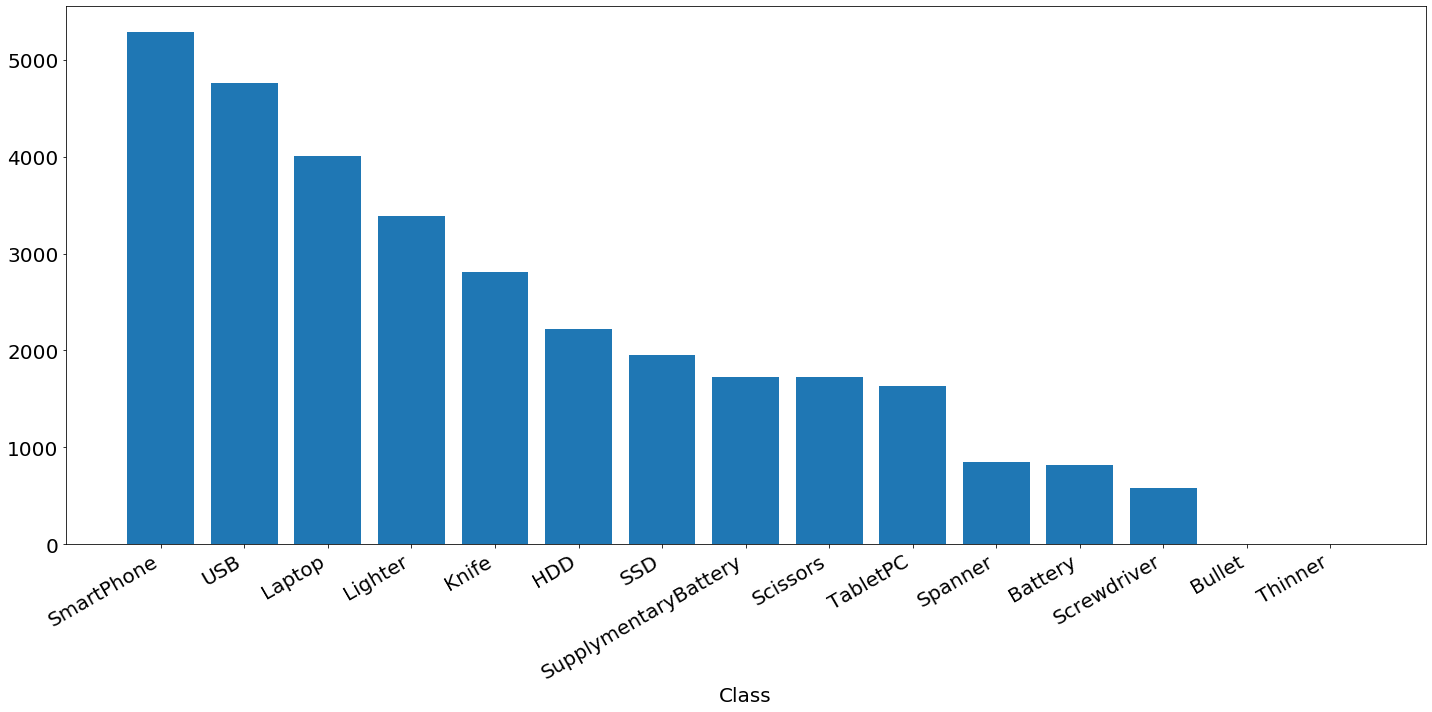

In [19]:
tmp = {ast_category_dict[key] : val for key, val in k.items()}
import collections
import operator
x = {1: 2, 3: 4, 4: 3, 2: 1, 0: 0}
sorted_x = sorted(tmp.items(), key=operator.itemgetter(1), reverse=True)
tmp2 = collections.OrderedDict(sorted_x)

fig, ax = plt.subplots(
    figsize=(20, 10)
)

ax.tick_params(axis="x", labelsize=20)
ax.tick_params(axis="y", labelsize=20)
fig.autofmt_xdate()
plt.bar(tmp2.keys(), tmp2.values())
ax.xaxis.label.set_size(25)
plt.xlabel('Class', fontsize=20)
plt.tight_layout()
plt.show()

### Machine : Rapiscan

In [26]:
rap_image_path_list, rap_label_list = get_path("./datasets/Annotation/Rapiscan.json")

In [27]:
rap_category_dict = get_category_index("./datasets/Annotation/Rapiscan.json")

In [28]:
rap_category_dict

{1: 'Aerosol',
 2: 'Alcohol',
 3: 'Awl',
 4: 'Axe',
 5: 'Bat',
 6: 'Battery',
 7: 'Bullet',
 8: 'Firecracker',
 9: 'Gun',
 10: 'GunParts',
 11: 'Hammer',
 12: 'HandCuffs',
 13: 'HDD',
 15: 'Knife',
 16: 'Laptop',
 17: 'Lighter',
 18: 'Liquid',
 19: 'Match',
 20: 'MetalPipe',
 21: 'NailClippers',
 22: 'PrtableGas',
 23: 'Saw',
 24: 'Scissors',
 25: 'Screwdriver',
 26: 'SmartPhone',
 27: 'SolidFuel',
 28: 'Spanner',
 29: 'SSD',
 30: 'SupplymentaryBattery',
 31: 'TabletPC',
 32: 'Thinner',
 33: 'USB',
 34: 'ZippoOil'}

In [29]:
new_rap_image_path_list = list(map(lambda image_path: "." + image_path, rap_image_path_list))

In [30]:
rap_df = pd.DataFrame(list(zip(new_rap_image_path_list, rap_label_list)), columns=['path', 'label'])
rap_df.head()

path  label
0  ./datasets/Rapiscan/USB/Single_Default/S_8544....     33
1  ./datasets/Rapiscan/USB/Single_Default/S_8544....     33
2  ./datasets/Rapiscan/USB/Single_Default/S_8544....     33
3  ./datasets/Rapiscan/USB/Single_Default/S_8544....     33
4  ./datasets/Rapiscan/USB/Single_Default/S_8544....     33

In [33]:
len(set(rap_df['label']))

18

In [31]:
rap_df.shape

(32267, 2)

In [34]:
# Astrophysics
k = {}
for i in rap_df['label']:
    if i not in k.keys():
        k[i] = 1
    else:
        k[i] += 1

k

{33: 5622,
 32: 2,
 24: 2350,
 17: 3417,
 6: 1794,
 15: 4846,
 5: 2,
 30: 628,
 26: 5231,
 28: 356,
 29: 1845,
 13: 3161,
 21: 302,
 7: 1,
 20: 1,
 11: 2,
 31: 1963,
 16: 744}

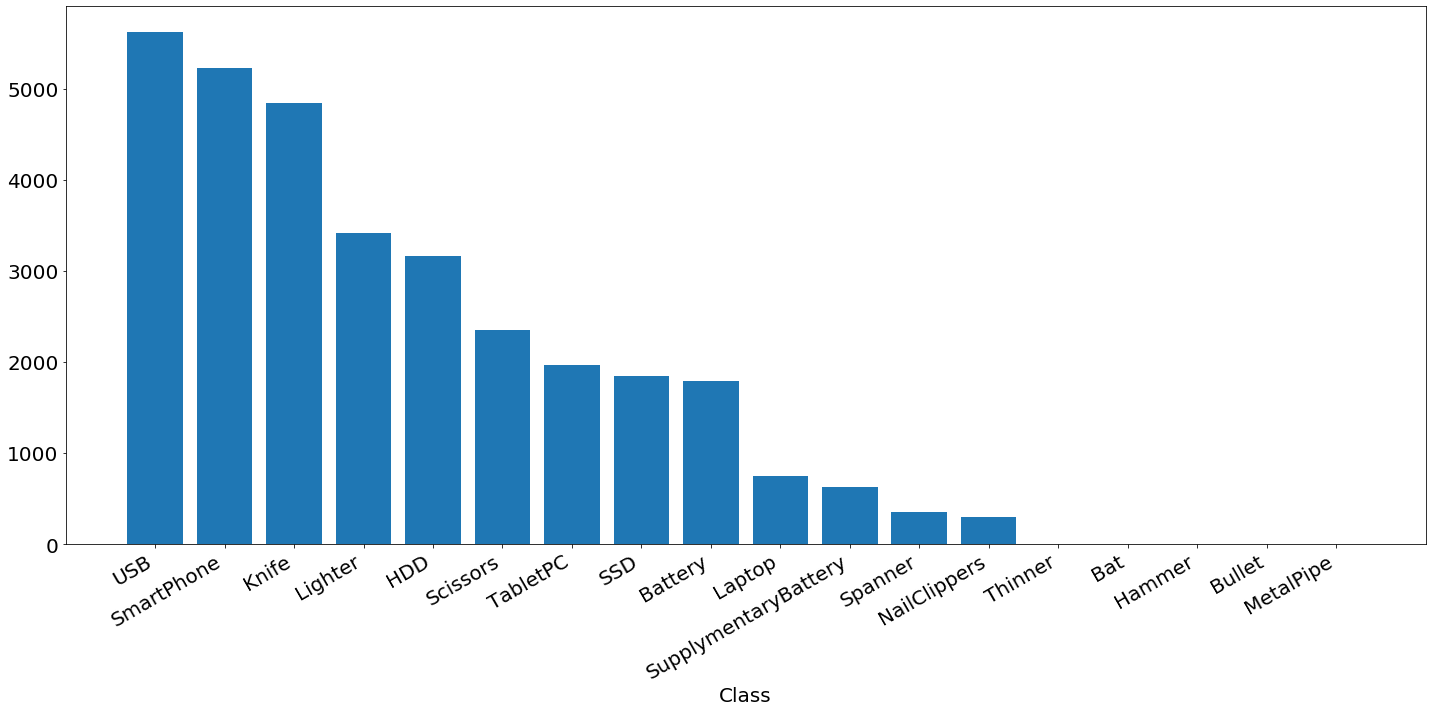

In [35]:
tmp = {ast_category_dict[key] : val for key, val in k.items()}
import collections
import operator
x = {1: 2, 3: 4, 4: 3, 2: 1, 0: 0}
sorted_x = sorted(tmp.items(), key=operator.itemgetter(1), reverse=True)
tmp2 = collections.OrderedDict(sorted_x)

fig, ax = plt.subplots(
    figsize=(20, 10)
)

ax.tick_params(axis="x", labelsize=20)
ax.tick_params(axis="y", labelsize=20)
fig.autofmt_xdate()
plt.bar(tmp2.keys(), tmp2.values())
ax.xaxis.label.set_size(25)
plt.xlabel('Class', fontsize=20)
plt.tight_layout()
plt.show()

### Machine : Smith

In [36]:
smi_image_path_list, smi_label_list = get_path("./datasets/Annotation/Smith.json")

In [37]:
smi_category_dict = get_category_index("./datasets/Annotation/Smith.json")

In [38]:
smi_category_dict

{1: 'Aerosol',
 2: 'Alcohol',
 3: 'Awl',
 4: 'Axe',
 5: 'Bat',
 6: 'Battery',
 7: 'Bullet',
 8: 'Firecracker',
 9: 'Gun',
 10: 'GunParts',
 11: 'Hammer',
 12: 'HandCuffs',
 13: 'HDD',
 15: 'Knife',
 16: 'Laptop',
 17: 'Lighter',
 18: 'Liquid',
 19: 'Match',
 20: 'MetalPipe',
 21: 'NailClippers',
 22: 'PrtableGas',
 23: 'Saw',
 24: 'Scissors',
 25: 'Screwdriver',
 26: 'SmartPhone',
 27: 'SolidFuel',
 28: 'Spanner',
 29: 'SSD',
 30: 'SupplymentaryBattery',
 31: 'TabletPC',
 32: 'Thinner',
 33: 'USB',
 34: 'ZippoOil'}

In [39]:
new_smi_image_path_list = list(map(lambda image_path: "." + image_path, smi_image_path_list))

In [40]:
smi_df = pd.DataFrame(list(zip(new_smi_image_path_list, smi_label_list)), columns=['path', 'label'])
smi_df.head()

path  label
0  ./datasets/Smith/USB/Single_Default/S_8544.42-...     33
1  ./datasets/Smith/USB/Single_Default/S_8544.42-...     33
2  ./datasets/Smith/USB/Single_Default/S_8544.42-...     33
3  ./datasets/Smith/USB/Single_Default/S_8544.42-...     33
4  ./datasets/Smith/USB/Single_Default/S_8544.42-...     33

In [42]:
len(set(smi_df['label']))

12

In [43]:
smi_df.shape

(27996, 2)

In [44]:
# Astrophysics
k = {}
for i in smi_df['label']:
    if i not in k.keys():
        k[i] = 1
    else:
        k[i] += 1

k

{33: 4590,
 6: 1254,
 17: 1416,
 15: 3299,
 24: 2437,
 28: 471,
 30: 594,
 26: 5465,
 13: 2647,
 29: 1858,
 31: 1849,
 16: 2116}

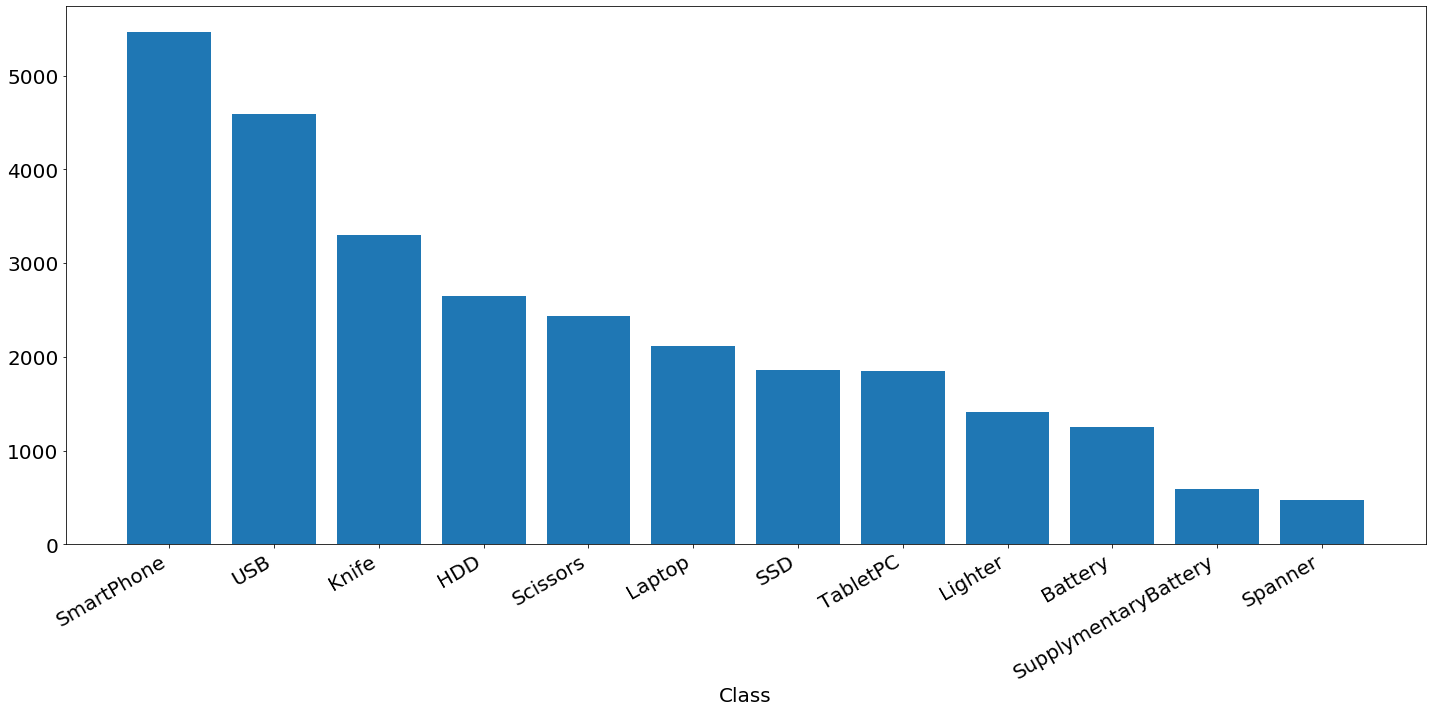

In [45]:
tmp = {ast_category_dict[key] : val for key, val in k.items()}
import collections
import operator
x = {1: 2, 3: 4, 4: 3, 2: 1, 0: 0}
sorted_x = sorted(tmp.items(), key=operator.itemgetter(1), reverse=True)
tmp2 = collections.OrderedDict(sorted_x)

fig, ax = plt.subplots(
    figsize=(20, 10)
)

ax.tick_params(axis="x", labelsize=20)
ax.tick_params(axis="y", labelsize=20)
fig.autofmt_xdate()
plt.bar(tmp2.keys(), tmp2.values())
ax.xaxis.label.set_size(25)
plt.xlabel('Class', fontsize=20)
plt.tight_layout()
plt.show()

### Save to .csv file

In [98]:
ast_df.to_csv("./csv_file/astrophysics.csv", header=False, index=False)

In [99]:
rap_df.to_csv("./csv_file/rapiscan.csv", header=False, index=False)

In [100]:
smi_df.to_csv("./csv_file/smith.csv", header=False, index=False)

### Test

In [101]:
ast_csv = pd.read_csv("./csv_file/astrophysics.csv")
ast_csv.head()

./datasets/Astrophysics/USB/Single_Default/S_8544.42-2090_01_200.png  33
0  ./datasets/Astrophysics/USB/Single_Default/S_8...                    33
1  ./datasets/Astrophysics/USB/Single_Default/S_8...                    33
2  ./datasets/Astrophysics/USB/Single_Default/S_8...                    33
3  ./datasets/Astrophysics/USB/Single_Default/S_8...                    33
4  ./datasets/Astrophysics/USB/Single_Default/S_8...                    33

## Elapsed Time

#### sampling_count = 1

In [14]:
start = time.time()

ast_data, ast_label = load_danger(
    data_path_list=new_ast_image_path_list,
    label_list=ast_label_list,
    category_dict=ast_category_dict,
    img_size=(256, 256),
    num_workers=10,
    min_class_data_size=30,
    sampling_count=1,
    sampling_ratio=0.2
)

end = time.time()

print("Elapsed Ti#### sampling_count=1me : {}".format(end - start))

Batch Size : 6352
Elapsed Time : 331.1627342700958


#### sampling_count = 2

In [41]:
start = time.time()

ast_data, ast_label = load_danger(
    data_path_list=new_ast_image_path_list,
    label_list=ast_label_list,
    category_dict=ast_category_dict,
    img_size=(256, 256),
    num_workers=10,
    min_class_data_size=30,
    sampling_count=2,
    sampling_ratio=0.2
)

end = time.time()

print("Elapsed Time : {}".format(end - start))

Batch Size : 6352
Elapsed Time : 339.87573170661926


#### sampling_count = 12

In [29]:
start = time.time()

ast_data, ast_label = load_danger(
    data_path_list=new_ast_image_path_list,
    label_list=ast_label_list,
    category_dict=ast_category_dict,
    img_size=(256, 256),
    num_workers=10,
    min_class_data_size=30,
    sampling_count=12,
    sampling_ratio=0.2
)

end = time.time()

print("Elapsed Time : {}".format(end - start))

KeyboardInterrupt: 

#### sampling_count = 12 || img_size = (avg width / 16, avg height / 16)

In [ ]:
start = time.time()

ast_data, ast_label = load_danger(
    data_path_list=new_ast_image_path_list,
    label_list=ast_label_list,
    category_dict=ast_category_dict,
    img_size=(int(ast_avg_img_size[0] / 16), int(ast_avg_img_size[1] / 16)),
    num_workers=10,
    min_class_data_size=30,
    sampling_count=12,
    sampling_ratio=0.2
)

end = time.time()

print("Elapsed Time : {}".format(end - start))

In [15]:
list(set(ast_label))

['Scissors',
 'USB',
 'SmartPhone',
 'Knife',
 'SupplymentaryBattery',
 'TabletPC',
 'Lighter',
 'Bat',
 'Screwdriver',
 'SSD',
 'Laptop',
 'HandCuffs',
 'Spanner']

In [16]:
data = ast_data
label = ast_label

## Verification

#### Original Data

In [266]:
label_count_dict = {'Aerosol': 0, 'Alcohol': 0, 'Awl': 0, 'Axe': 0, 'Bat': 813, 'Battery': 1, 'Bullet': 0, 'Firecracker': 0, 'Gun': 0, 'GunParts': 0, 'Hammer': 0, 'HandCuffs': 2218, 'HDD': 0, 'Knife': 2810, 'Laptop': 4008, 'Lighter': 3384, 'Liquid': 0, 'Match': 0, 'MetalPipe': 0, 'NailClippers': 0, 'PrtableGas': 0, 'Saw': 0, 'Scissors': 1724, 'Screwdriver': 583, 'SmartPhone': 5286, 'SolidFuel': 0, 'Spanner': 852, 'SSD': 1958, 'SupplymentaryBattery': 1727, 'TabletPC': 1630, 'Thinner': 1, 'USB': 4759, 'ZippoOil': 0}

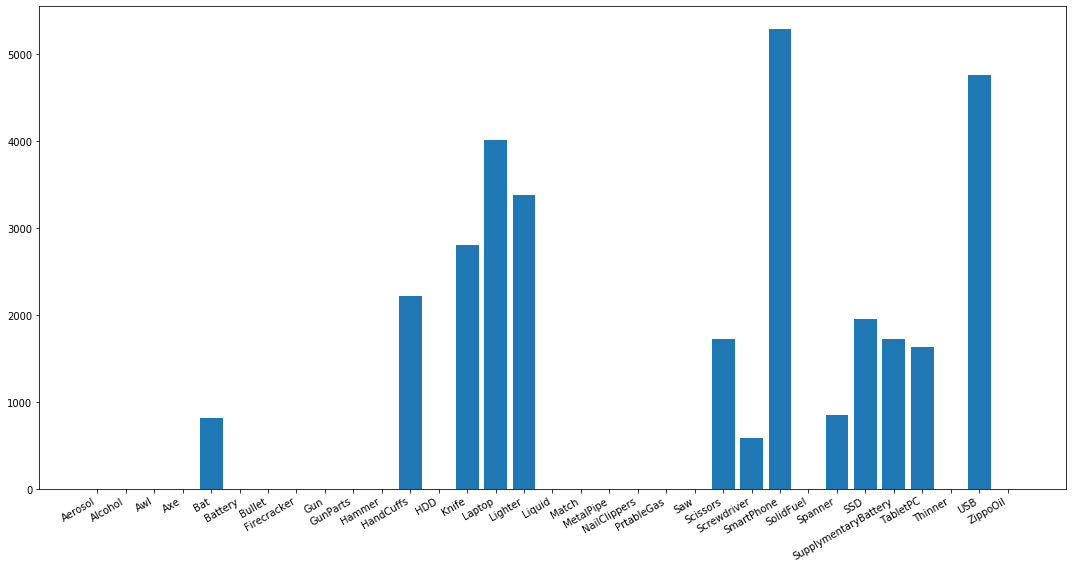

In [267]:
fig, ax = plt.subplots(
    figsize=(15, 8)
)
fig.autofmt_xdate()
plt.bar(label_count_dict.keys(), label_count_dict.values())

plt.tight_layout()
plt.show()

#### Dataloader Data

In [17]:
label_set = list(set(label))
new_label_count_dict = {label: 0 for label in label_set}

for label_value in label:
    new_label_count_dict[label_value] += 1

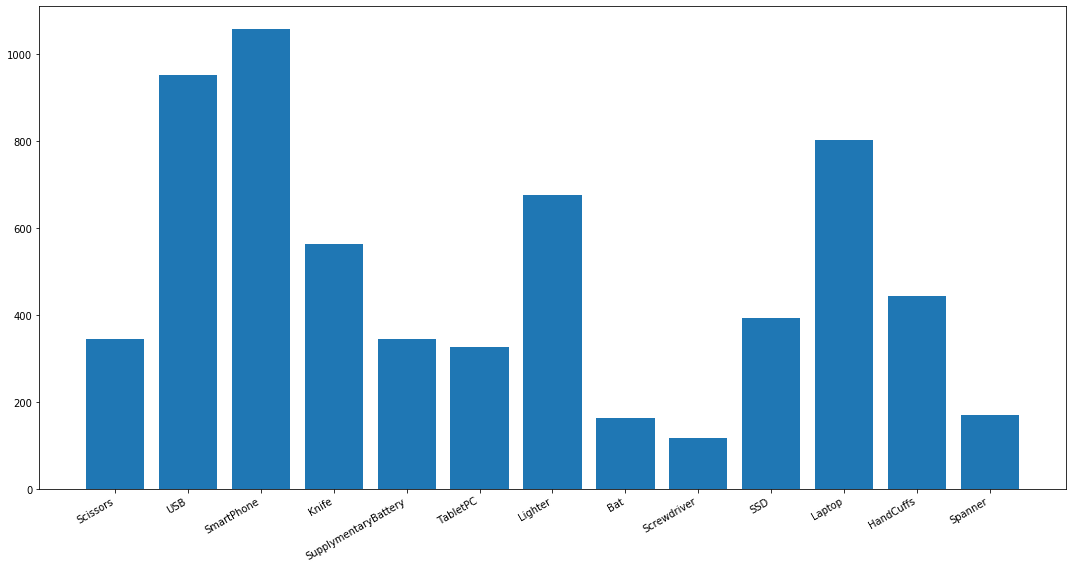

In [18]:
fig, ax = plt.subplots(
    figsize=(15, 8)
)
fig.autofmt_xdate()
plt.bar(new_label_count_dict.keys(), new_label_count_dict.values())

plt.tight_layout()
plt.show()

## Image Test (image-label 이 올바르게 매칭되지 않음)

In [19]:
idx = 300

In [20]:
img_3d = ast_data[idx].reshape((3, 256, 256))
img_3d = img_3d.transpose(1, 2, 0)

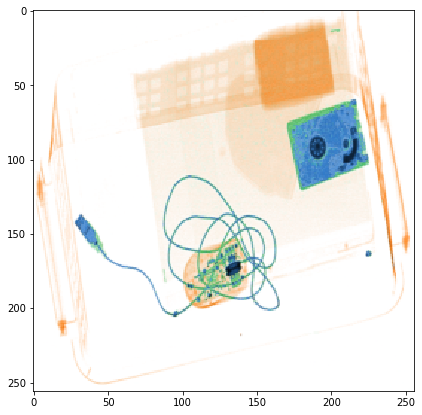

In [21]:
plt.figure(figsize=(15, 7))
plt.imshow(img_3d)

plt.show()

In [22]:
ast_label[idx]

'HandCuffs'

## Verification - Stratified Sampling

In [26]:
sampling_ratio=0.01
min_class_data_size = 30
img_size=(2, 2)
num_workers=10

preprocessed_data_path_list, preprocessed_label_list, class_vector_label_list, label_idx_dict \
        = preprocessing_data(new_ast_image_path_list, ast_label_list, ast_category_dict, min_class_data_size)

label_count_dict = {key: 0 for key in list(set(preprocessed_label_list))}

# 각 class 의 데이터 갯수 셈
for label in preprocessed_label_list:
    label_count_dict[label] += 1

batch_size = int(np.sum([round(class_instance_num * sampling_ratio) for _, class_instance_num in label_count_dict.items() 
                     if class_instance_num >= min_class_data_size]))

print("Batch Size : {}".format(batch_size))

sampler = StratifiedSampler(
    label_dict=label_idx_dict,
    sampling_count=12,
    class_instance_dict=label_count_dict,
    batch_size=batch_size,
    sampling_ratio=sampling_ratio, 
    min_class_data_size=min_class_data_size
)

danger_data = DangerDataset(preprocessed_data_path_list, preprocessed_label_list, img_size)

danger_loader = DataLoader(
    danger_data,
    batch_size=batch_size,
    sampler=sampler,
    num_workers=num_workers
)

Batch Size : 318


In [40]:
batch_num = 0
for idx, data in enumerate(danger_loader):
    batch_num += 1
    #print(batch.shape)
    print(data[1])
    label  = data[1]
#     print(label.shape)
    label_dict = {}
    for i in label:
        if i.item() not in label_dict.keys():
            label_dict[i.item()] = 1
        else:
            label_dict[i.item()] += 1
    print(label_dict)
    print("----------")
print(batch_num)

('Bat', 'Bat', 'Bat', 'Bat', 'Bat', 'Bat', 'Bat', 'Bat', 'HandCuffs', 'HandCuffs', 'HandCuffs', 'HandCuffs', 'HandCuffs', 'HandCuffs', 'HandCuffs', 'HandCuffs', 'HandCuffs', 'HandCuffs', 'HandCuffs', 'HandCuffs', 'HandCuffs', 'HandCuffs', 'HandCuffs', 'HandCuffs', 'HandCuffs', 'HandCuffs', 'HandCuffs', 'HandCuffs', 'HandCuffs', 'HandCuffs', 'Knife', 'Knife', 'Knife', 'Knife', 'Knife', 'Knife', 'Knife', 'Knife', 'Knife', 'Knife', 'Knife', 'Knife', 'Knife', 'Knife', 'Knife', 'Knife', 'Knife', 'Knife', 'Knife', 'Knife', 'Knife', 'Knife', 'Knife', 'Knife', 'Knife', 'Knife', 'Knife', 'Knife', 'Laptop', 'Laptop', 'Laptop', 'Laptop', 'Laptop', 'Laptop', 'Laptop', 'Laptop', 'Laptop', 'Laptop', 'Laptop', 'Laptop', 'Laptop', 'Laptop', 'Laptop', 'Laptop', 'Laptop', 'Laptop', 'Laptop', 'Laptop', 'Laptop', 'Laptop', 'Laptop', 'Laptop', 'Laptop', 'Laptop', 'Laptop', 'Laptop', 'Laptop', 'Laptop', 'Laptop', 'Laptop', 'Laptop', 'Laptop', 'Laptop', 'Laptop', 'Laptop', 'Laptop', 'Laptop', 'Laptop', 'Ligh

## Cropped Sample Images

In [33]:
ast_image_path_list, ast_label_list = get_path("./datasets/Annotation/Astrophysics.json")

In [34]:
rap_image_path_list, rap_label_list = get_path("./datasets/Annotation/Rapiscan.json")

In [35]:
smi_image_path_list, smi_label_list = get_path("./datasets/Annotation/Smith.json")

In [42]:
ast_category_dict = get_category_index("./datasets/Annotation/Astrophysics.json")
rap_category_dict = get_category_index("./datasets/Annotation/Rapiscan.json")
smi_category_dict = get_category_index("./datasets/Annotation/Smith.json")

In [36]:
new_ast_image_path_list = list(map(lambda image_path: "." + image_path, ast_image_path_list))
new_rap_image_path_list = list(map(lambda image_path: "." + image_path, rap_image_path_list))
new_smi_image_path_list = list(map(lambda image_path: "." + image_path, smi_image_path_list))

In [37]:
print(len(new_ast_image_path_list), len(new_rap_image_path_list), len(new_smi_image_path_list))

31754 32267 27996


In [38]:
ast_danger_data = DangerDataset(new_ast_image_path_list, ast_label_list, img_size=(256, 256))
rap_danger_data = DangerDataset(new_rap_image_path_list, rap_label_list, img_size=(256, 256))
smi_danger_data = DangerDataset(new_smi_image_path_list, smi_label_list, img_size=(256, 256))

### Astrophysics

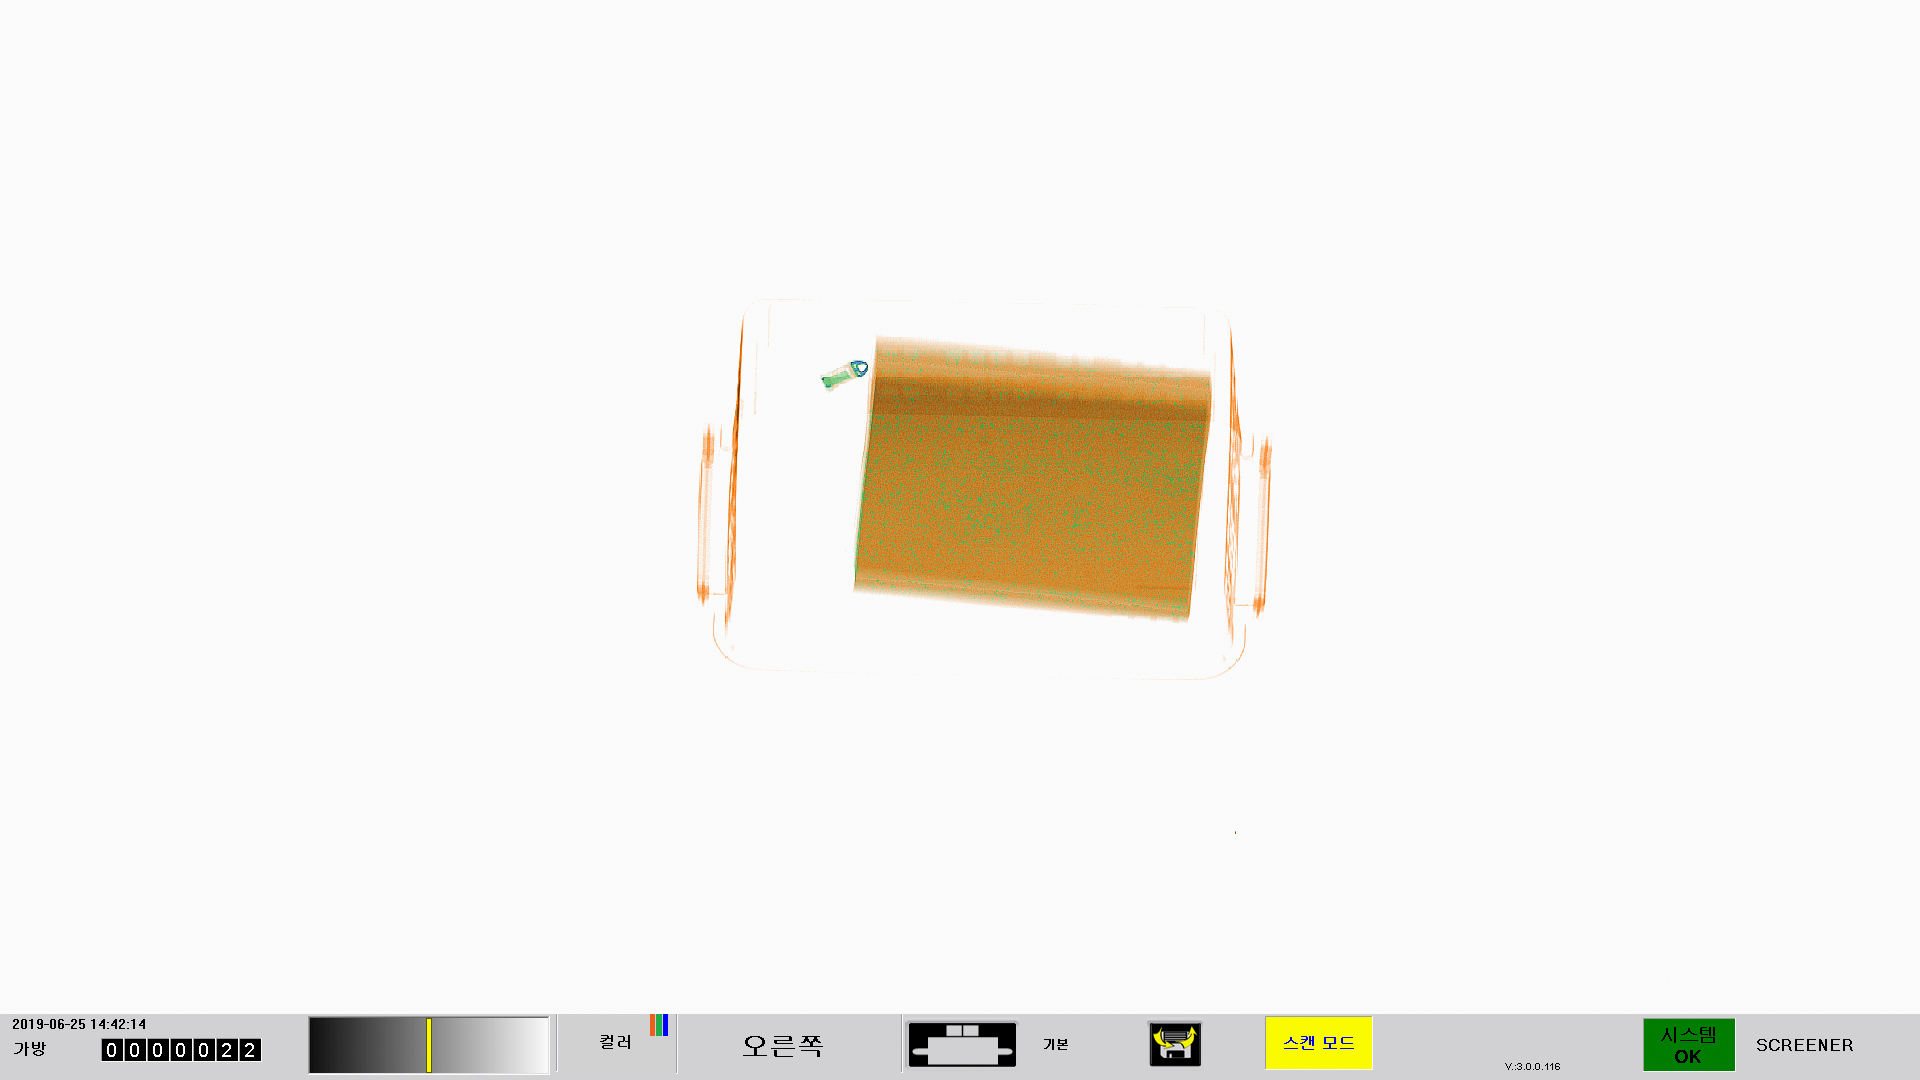

In [112]:
img = Image.open(new_ast_image_path_list[0])
img

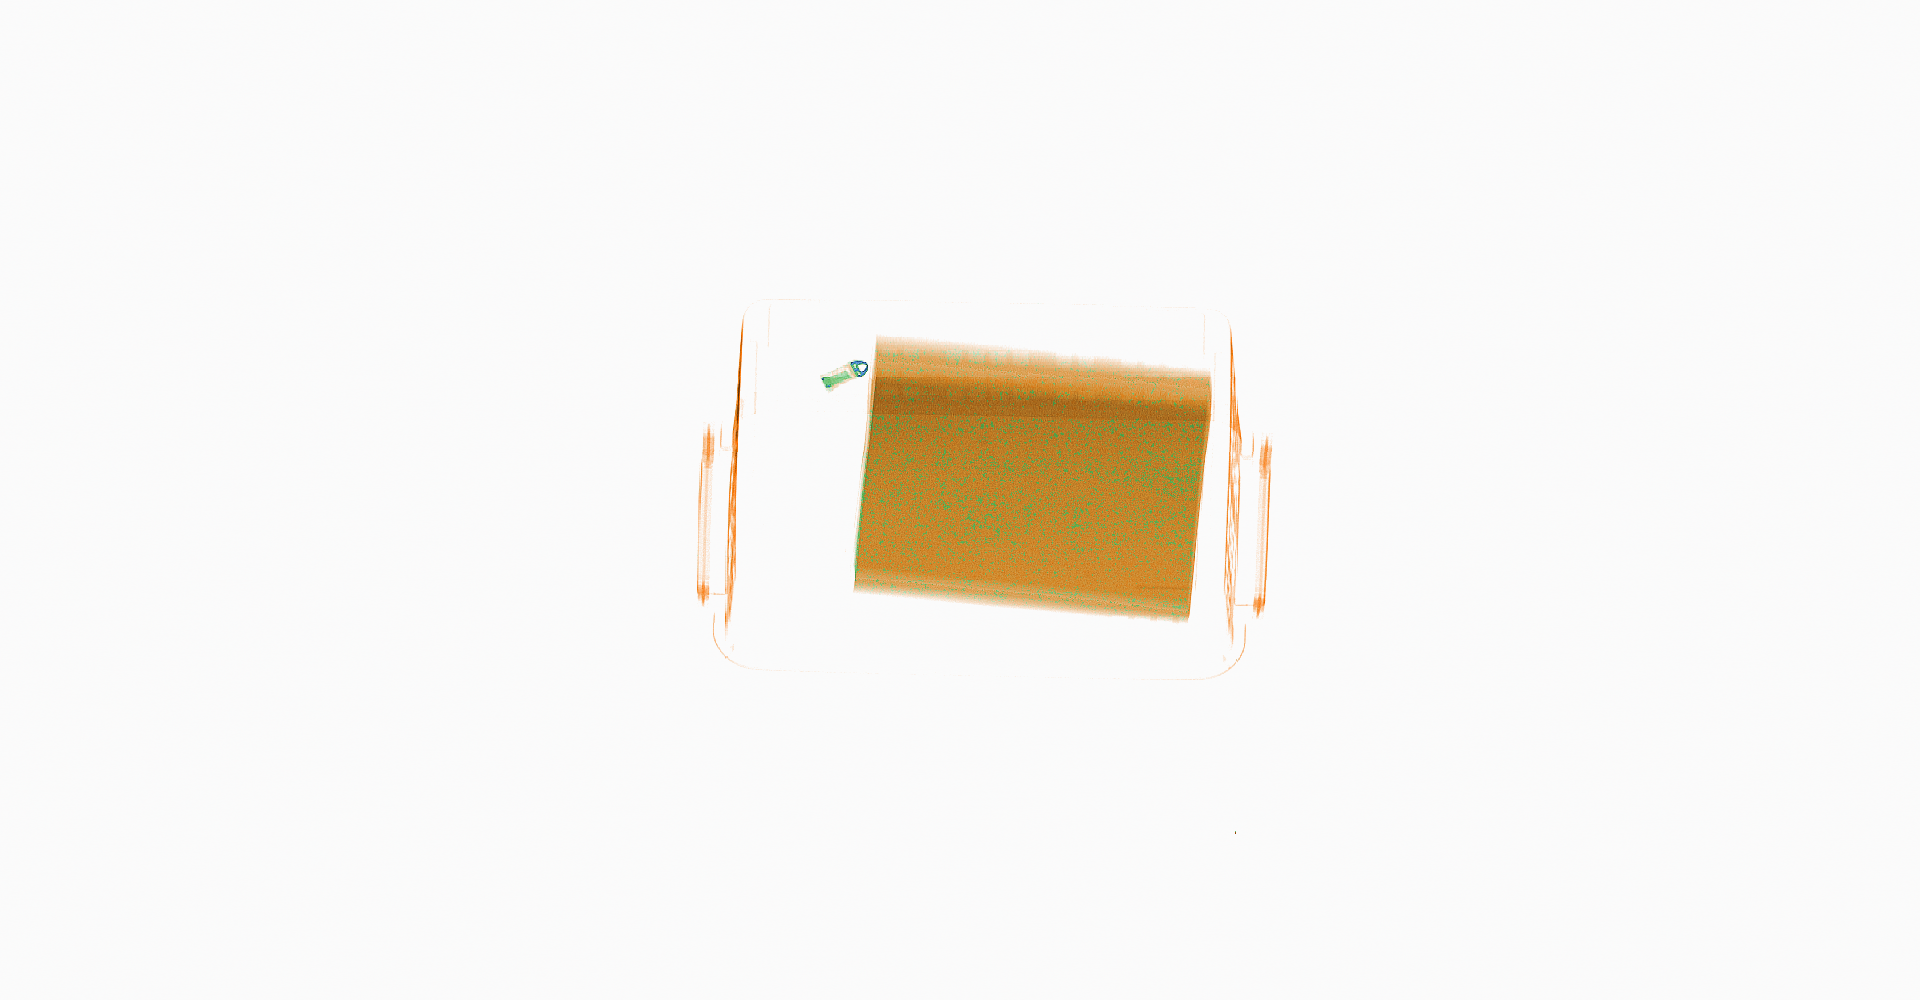

In [119]:
img = cv2.imread(new_ast_image_path_list[0])

img = img[:ASTROPHYSICS_LAYOUT_HEIGHT_BOUNDARY, :]
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img = Image.fromarray(img)

img

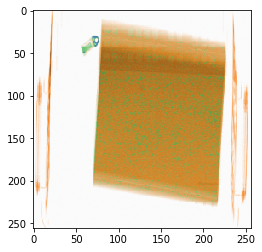

In [128]:
plt.imshow(ast_danger_data[0][0].numpy().transpose(1, 2, 0))
plt.show()

In [43]:
ast_category_dict[ast_danger_data[0][1]]

'USB'

### Rapiscan

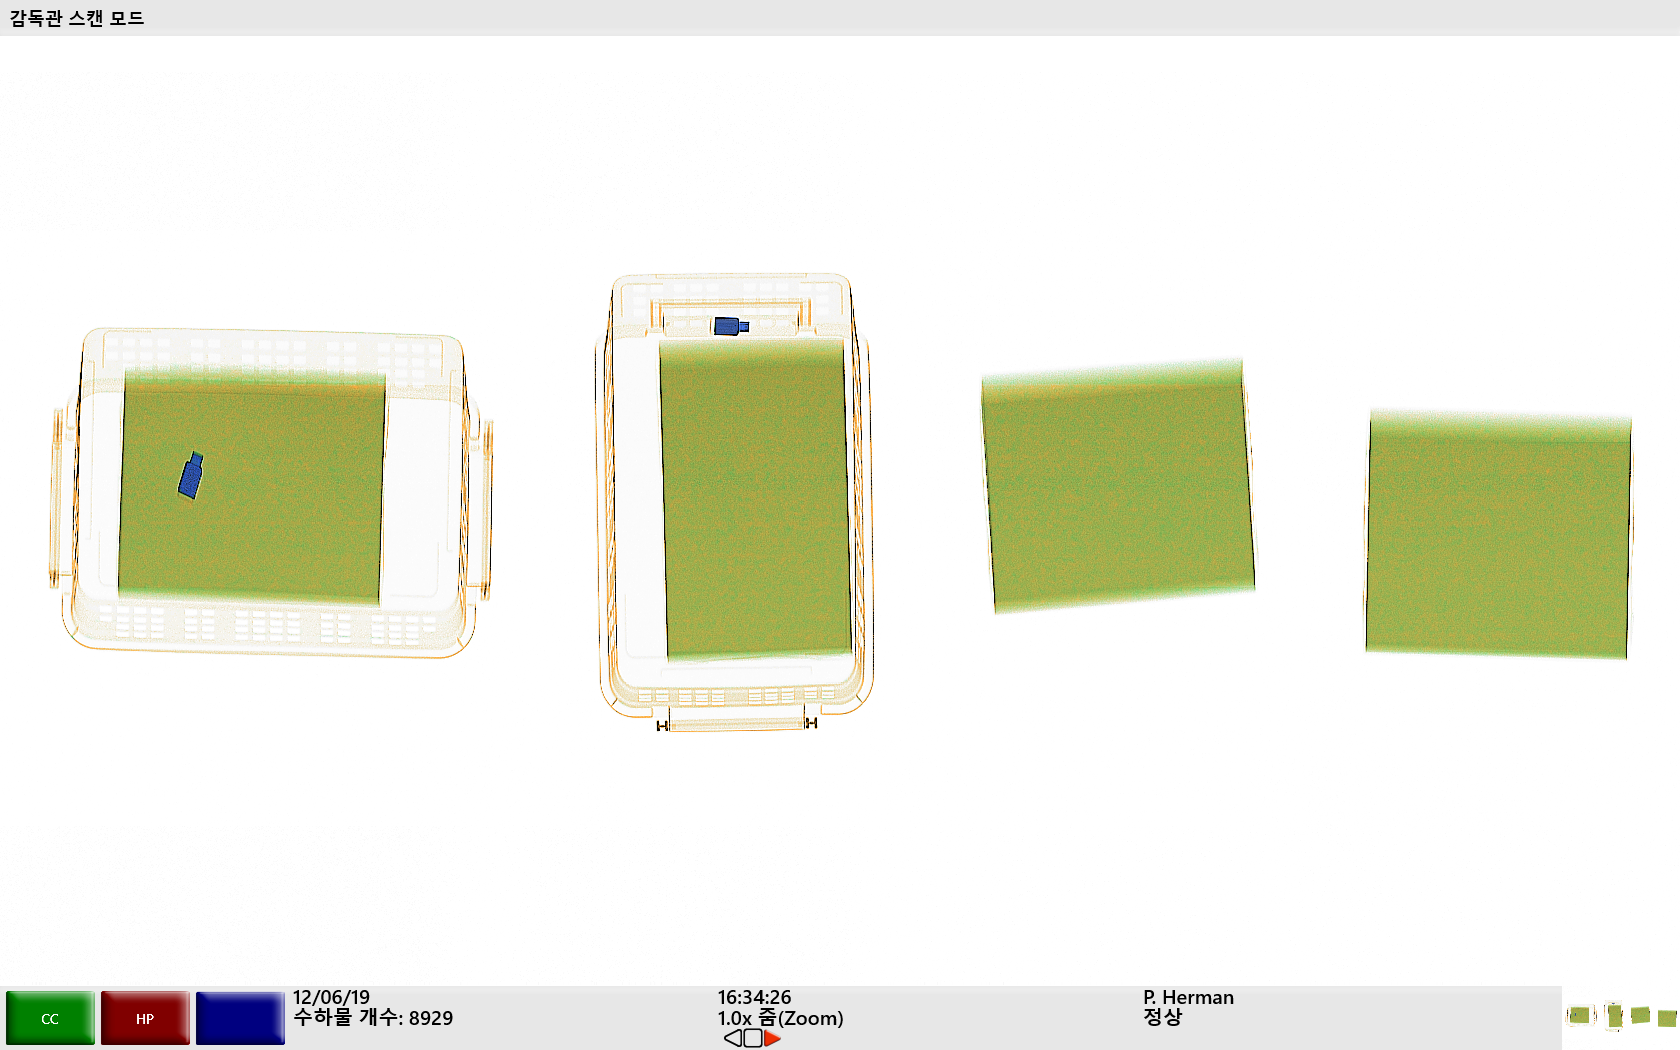

In [110]:
img = Image.open(new_rap_image_path_list[0])
img

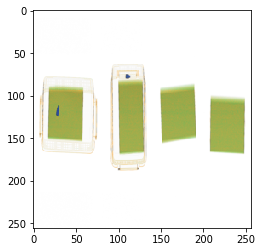

In [49]:
plt.imshow(rap_danger_data[0][0].numpy().transpose(1, 2, 0))
plt.show()

In [48]:
rap_category_dict[rap_danger_data[0][1]]

'USB'

### Smith

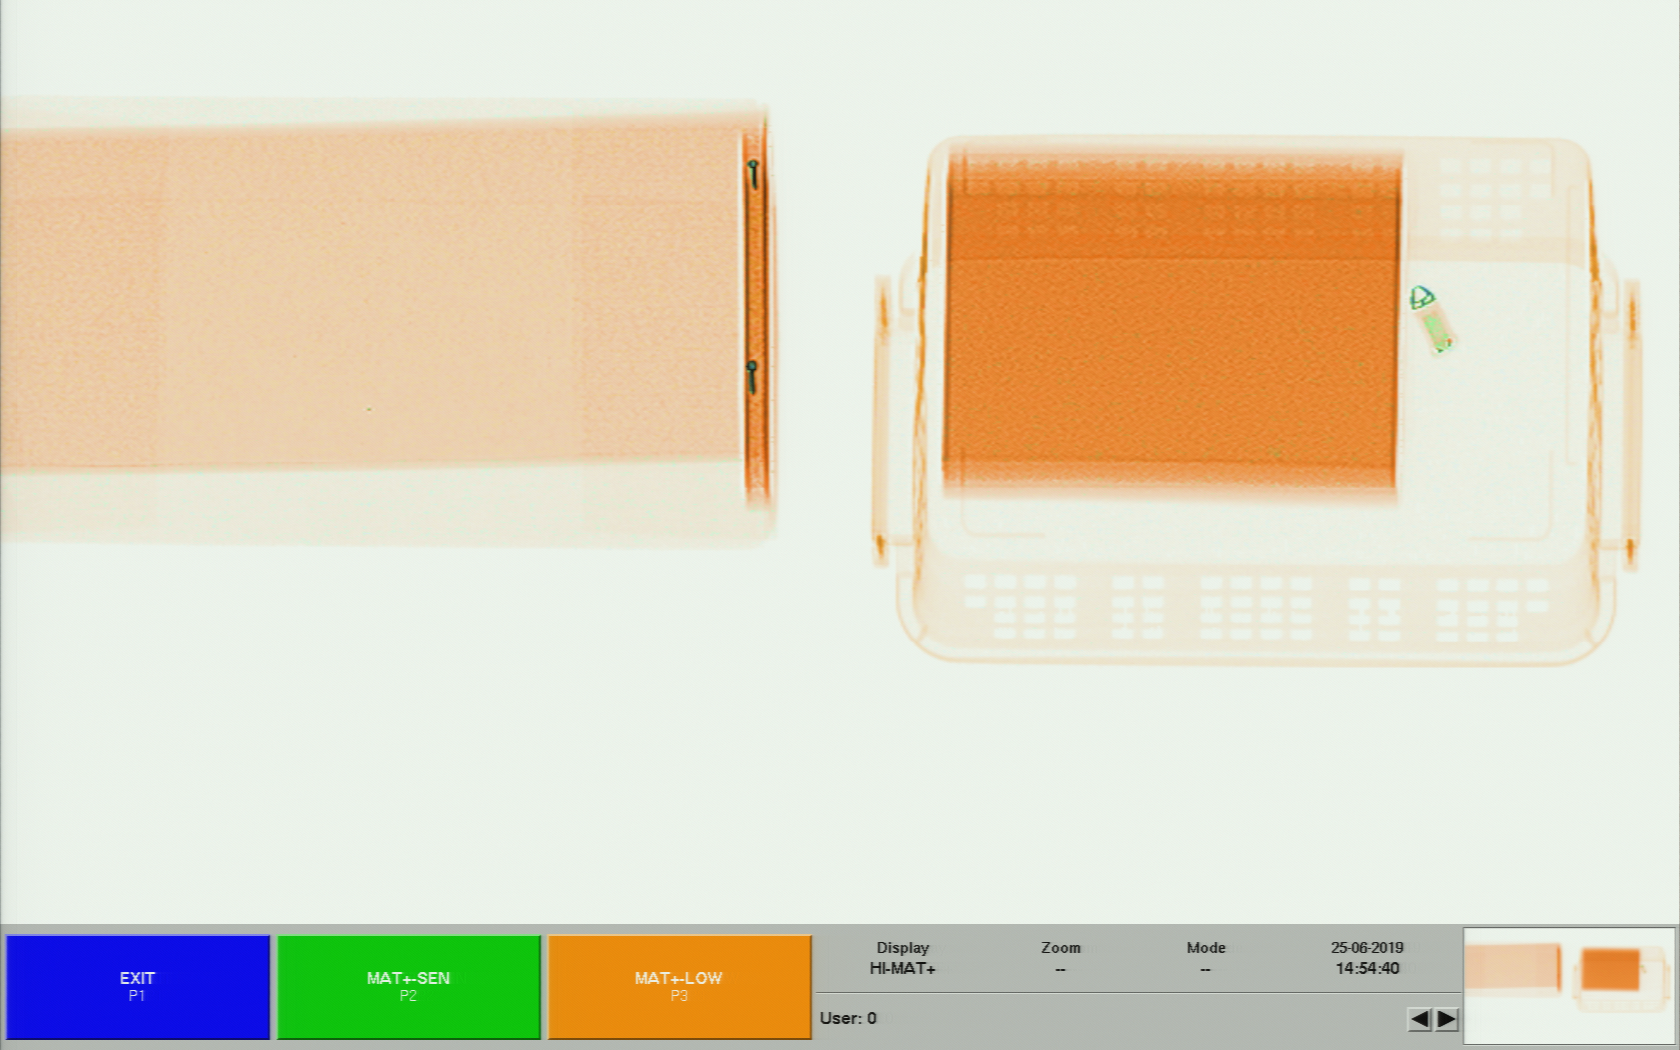

In [111]:
img = Image.open(new_smi_image_path_list[0])
img

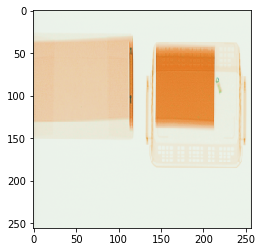

In [51]:
plt.imshow(smi_danger_data[0][0].numpy().transpose(1, 2, 0))
plt.show()

In [50]:
smi_category_dict[smi_danger_data[0][1]]

'USB'